# 0 - inicjalizacja zbiorów i importy

In [37]:
N=3 # Ilosc uruchomien per rozwiązanie

In [38]:
#imports
from scipy.spatial import distance_matrix
from random import randrange
import copy
import matplotlib.pyplot as plt
import imageio
import imageio
import random
from time import time
from tqdm import tqdm

In [39]:
#loading datasets 
import numpy as np
kroa={}
krob={}
np_kroa=[]
np_krob=[]
with open('kroa200.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        kroa[x[0]]=(x[1],x[2])
        np_kroa.append((x[1],x[2]))
np_kroa=np.array(np_kroa)
with open('krob200.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        krob[x[0]]=(x[1],x[2])
        np_krob.append((x[1],x[2]))

np_kroa=np.array(np_kroa)
np_krob=np.array(np_krob)

#calculating distance matrix - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html
dista=distance_matrix(np_kroa,np_kroa)
distb=distance_matrix(np_krob,np_krob)

In [40]:
#plotting functions
def plotResult(np_dots, cycles):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.show()
    
def plotPartResult(np_dots, cycles,i):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.plot(np_dots[:,0], np_dots[:,1], ".")
    plt.savefig(f'plots/{i}.png')
    plt.show()    
def calcDistance(currentCycle, dist):
    distance = 0
    for x,y in zip(currentCycle, [*currentCycle[1:], currentCycle[0]]):
        distance += dist[x][y]
    return distance 

# 1 - Najlepsza heurstyka z Lab1 (Metoda rozbudowy cyklu)

In [41]:
def findNewCycle(currentCycle, newV, dist):
    distance = 0
    minNewCycle = None
    minDistance = np.inf
    for i in range(len(currentCycle)+1):
        newCycle = copy.deepcopy(currentCycle)
        newCycle.insert(i, newV)
        distance = calcDistance(newCycle, dist)
        
        if distance < minDistance:
            minDistance = distance 
            minNewCycle = newCycle
        
    return minDistance, minNewCycle

0
1
2
35675.729466680954 39807.89981764711 38004.53150330752


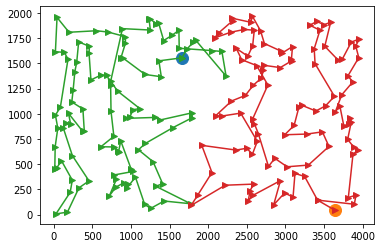

0
1


In [ ]:


#THE DATASET - który zbior wybieramy
for choice in ["kroa","krob"]:
    #INITIALIZING RESULTS VARIABLES
    results=[]
    min_result=np.inf
    max_result=0
    if choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)

    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(dista)


    #zmiana dystansu przekątnej na nieskonczonosc
    np.fill_diagonal(dist, np.inf)

    #LOOP TO GATHER ALL RESULTS
    for i in range(0,N):
        print(i)
        cycles={}
        cycles[0]=[]
        cycles[1]=[]
        #mając macierz odległosci dodawac zawsze najblizszy wobec wszystkich i wstawiac go w cykl po tym dla ktorego odleglosc znaleziono

        # select starting vertex
        cycles[0].append(randrange(200))
        cycles[1].append(np.argsort(dist[cycles[0][0]])[-2])
        #print(cycles)
        chosenCycle = 1
        for i in range(198):
            #print(i)
            chosenCycle = (chosenCycle + 1)%2
            minDistance = np.inf
            minVertex = None
            minPath = None

            for vertex in range(len(dist)):
                if vertex in [*cycles[0], *cycles[1]]: 
                    continue
                distance, path = findNewCycle(cycles[chosenCycle], vertex, dist)
                if distance < minDistance:
                    minDistance = distance
                    minVertex = vertex
                    minPath = path
            #print(f"chosenCycle: {chosenCycle}; minVertex: {minVertex}, minDistance: {minDistance}")
            cycles[chosenCycle] = minPath

           # if chosenCycle % 2 == 1:
           #     plotPartResult(dataset, cycles, i)


        #SAVING RESULTS 
        results.append(calcDistance(cycles[0],dist_stable)+calcDistance(cycles[1],dist_stable))
        if results[-1]>max_result:
            max_result=results[-1]
        if results[-1]<min_result:
            min_result=results[-1]
            plt.clf()
            plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
            plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)
            plt.plot(dataset[:,0][[*cycles[0],cycles[0][0]]], dataset[:,1][[*cycles[0],cycles[0][0]]], "->")
            plt.plot(dataset[:,0][[*cycles[1],cycles[1][1]]], dataset[:,1][[*cycles[1],cycles[1][1]]], "->")
            plt.savefig(f'best_zad2_{choice}.png')



    #SAVING RESULTS
    average_result=np.mean(np.array(results))
    with open(f"zad2_results_{choice}.txt","w") as f:
        f.write(f"{average_result} ({min_result} - {max_result})")

    #SHOWING RESULTS HERE
    print(min_result,max_result,average_result)
    plt.show()


# 2 - Najlepszy czysty Steepest search (bez listy możliwych ruchów ani ruchów kandydackich)

In [43]:
# 1st variable - Start cycle - with nearest neighbour method
def start_cycle_heuristic(dataset_choice="kroa"):
    results=[]
    min_result=np.inf
    max_result=0
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)

    #zmiana dystansu przekątnej na nieskonczonosc
    np.fill_diagonal(dist, np.inf)

    cycles={}
    cycles[0]=[randrange(200)]
    cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]

    for b in range(2):
        dist[:,int(cycles[b][0])]=np.inf

    chosenCycle=1
    for i in range(0,198):
        chosenCycle = int((chosenCycle + 1)%2)
        candidates=[]
        for z,index in enumerate(cycles[chosenCycle]):
            candidates.append((np.argmin(dist[index]),np.min(dist[index]),z))
        candidates=np.array(candidates)
        x=np.argmin(candidates[:,1])
        cycles[chosenCycle]=np.insert(cycles[chosenCycle],int(candidates[x,2]),int(candidates[x,0]))
        dist[:,int(candidates[x,0])]=np.inf
    
    #SAVING RESULTS 
    results.append(calcDistance(cycles[0],dist_stable)+calcDistance(cycles[1],dist_stable))
    if results[-1]>max_result:
        max_result=results[-1]
    if results[-1]<min_result:
        min_result=results[-1]
    return cycles

In [44]:
# 2nd variable - Find more optimal solution
def steep_search(dist, np_dots, init_random = False, switch="change_edges"):
    #specify cycles initialization.
    cycles = start_cycle_heuristic()
    
    #Define internal change
    internal_change = change_edges
    
    bestDistance = 0
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist) 
    finish=False
    
    while not finish:
        
        #-------------calculating possible moves
        mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
        combinations = mesh.T.reshape(-1, 2)
        possible_moves={'external': [combinations]}
        mesh = np.array(np.meshgrid(cycles[0], cycles[0]))
        mesh = np.concatenate((mesh,np.array(np.meshgrid(cycles[1], cycles[1]))),axis=0)
        combinations = mesh.T.reshape(-1, 2)
        possible_moves['internal']=[combinations]
        #-------------------finished calculating possible moves
        
        currentbestDist=bestDistance
        finish=True
        for k,v in possible_moves.items():
            for value in v[0]:
                new_cycles=copy.deepcopy(cycles)
                #print("BBBBB",value)
                #print("AAA",value)
                if k=="internal":
                    new_cycles=internal_change(new_cycles,value[0],value[1],True)
                elif k=="external":
                    new_cycles=change_vertices(new_cycles,value[0],value[1],False)
                currentDist=calcDistance(new_cycles[0], dist) 
                currentDist+=calcDistance(new_cycles[1], dist)
                if currentbestDist>currentDist:
                    supercycles=copy.deepcopy(new_cycles)
                    currentbestDist=currentDist
        if bestDistance!=currentbestDist:       
            cycles=copy.deepcopy(supercycles)
            bestDistance=currentbestDist
            finish=False
    return cycles,bestDistance

In [45]:
# 3rd variable - Generate neighbour solution
#changes edges internally
def change_edges(cycles, edge1, edge2, internally=False): # dummy internally
    cI= 0 if len(np.where(cycles[0] == edge1)[0])!=0 else 1 
    inA=np.where(cycles[cI] == edge1)[0][0]
    inB=np.where(cycles[cI] == edge2)[0][0]
    inA += 1
    inB += 1
    cycle = cycles[cI]
    cycle[inA: inB] = np.flip(cycle[inA: inB])
    return cycles

In [46]:
#changes vertex externaly between cycles
def change_vertices(cycles, a, b, internally=False):
    if internally:
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI][inB]=tmp
    else:
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        cI2 = 1-cI
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI2] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI2][inB]=tmp
    return cycles

In [47]:
# uruchomienie najlepszego czystego steepest (Heuristic+Steep+Change edges)


dataset_choice = "kroa"
search = steep_search


for dataset_choice in ['kroa', 'krob']:
    if dataset_choice=="kroa":
        dataset=np_kroa
        dist=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dist=copy.deepcopy(distb)
        
    timeTable = []
    distanceTable = []
    cyclesTable = []
    bestDistance = 0
    for _ in tqdm(range(N)):
        startTime = time()
        cycles, bestDistance = search(dist, dataset, 60, switch=switch)
        distanceTable.append(bestDistance)
        cyclesTable.append(cycles)
        timeTable.append(time() - startTime)
    print(f"RANDOM_- {search.__name__} Switch- {switch} Init_random- {init_random} Dataset- {dataset_choice}; time_mean:{np.mean(timeTable)},  time_min:{np.min(timeTable)}, time_max:{np.max(timeTable)}, min:{np.min(distanceTable)}, max:{np.max(distanceTable)}, mean:{np.mean(distanceTable)}")


    plt.clf()
    plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)                
    plt.plot(dataset[:,0][[*cycles[0],cycles[0][0]]], dataset[:,1][[*cycles[0],cycles[0][0]]], "->")
    plt.plot(dataset[:,0][[*cycles[1],cycles[1][1]]], dataset[:,1][[*cycles[1],cycles[1][1]]], "->")

    plt.savefig(f'RANDOM_best_NN_{search.__name__}_random{init_random}_{switch}_{dataset_choice}.png')


 33%|███▎      | 1/3 [00:17<00:34, 17.09s/it]


KeyboardInterrupt: 

# 3 - Steepest search z listą możliwych ruchów

# 4 - Steepest search z ruchami kandydackimi